# WAMIDA Statistical Analysis

## Author: Ricky Hu

This Jupyter notebook displays the statistical processing of the WAMIDA data. Note that the imported data is only available locally on a host machine and this code will not run without the exact same filename accessible by this notebook

## Method:

Analysis has 3 components

**1. Data Prepocessing and Cleaning**

Data is cleaned, with irrelevant data removed, including analysis of Variance Inflation Factor for colinearity and a confusion matrix to highlight low variance variables. Categorical variables are changed into dummy variables for binary categories.

**2. Exploratory Data Analysis**

We can conduct a wilcoxon test for continuous data and fisher exact test for binary data. We can also compute Pearson correlation coefficients as well. Note that the p-values are not representative of how significant a logistic fit is (this is what we really want in the end), but this can allow us to be exploratory to see which variables are very viable or very unviable for logistic regression fit.

**3. Logistic Regression, Refactoring Low Significance Variables and Re-fitting**

The remaining significant data is placed into a logistic regression model using a maximum likelihood estimate algorithm. The odds ratio of each variable is reported along with P-value The high-p variables are removed and then logistic regression is re-fitted to achieve a higher accruacy fit. Odds ratios can then be reported.

# 1. Preprocessing

In [2]:
# Setup, imports

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from patsy import dmatrices
import statsmodels.api as sm 
import seaborn as sn
from scipy.stats import wilcoxon
import scipy.stats as stats

matplotlib.rcParams['figure.figsize'] = [40, 20]

In [7]:
data = pd.read_excel('data_input.xlsx')

#Age has a space afterward in the spreadsheet,
cols_num = ['Age ', 'Pack Years', 'Drinks/Week', 'Height', 'Weight', 'BMI', 'HADS D', 'HADS A']
data_num = data[cols_num]
data_cat = data.drop(columns = cols_num)
print(data.columns)

Index(['Age ', 'Sex', 'Education Level', 'Employment', 'Income (2019)',
       'Marital Status', 'House Situation', 'Pack Years', 'Drinks/Week',
       'Hx Depression', 'Hx Anxiety ', 'Previous AMI', 'High Cholesterol',
       'Diabetes', 'Height', 'Weight', 'BMI', 'HADS D', 'HADS A', 'Bin Dep',
       'Bin Anx'],
      dtype='object')


# Exploratory Data Analysis

## Testing Colinearity with Variance Inflation Factor ,colinear variables would not be of statistical value and would be removed for a regression fit 

### Variables with VIF > 10 indicate covariance (R2 > 0.9)

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = data.iloc[:,:-4]
calc_vif(X)


,variables,VIF
0,Age,95.765196
1,Sex,8.862767
2,Education Level,3.628227
3,Employment,3.861008
4,Income (2019),5.813285
5,Marital Status,5.360591
6,House Situation,3.531493
7,Pack Years,3.718050
8,Drinks/Week,1.841429
9,Hx Depression,2.794644


## As expected, BMI is colinear with heigh and weight (also expected), Rooms and people measure are also colinear. We can then remove the colinear variables.

## We can visualize pearson correlation of the with a correlation matrix 

## (Colinear variables remaining for completeness, will be removed for regression fitting)

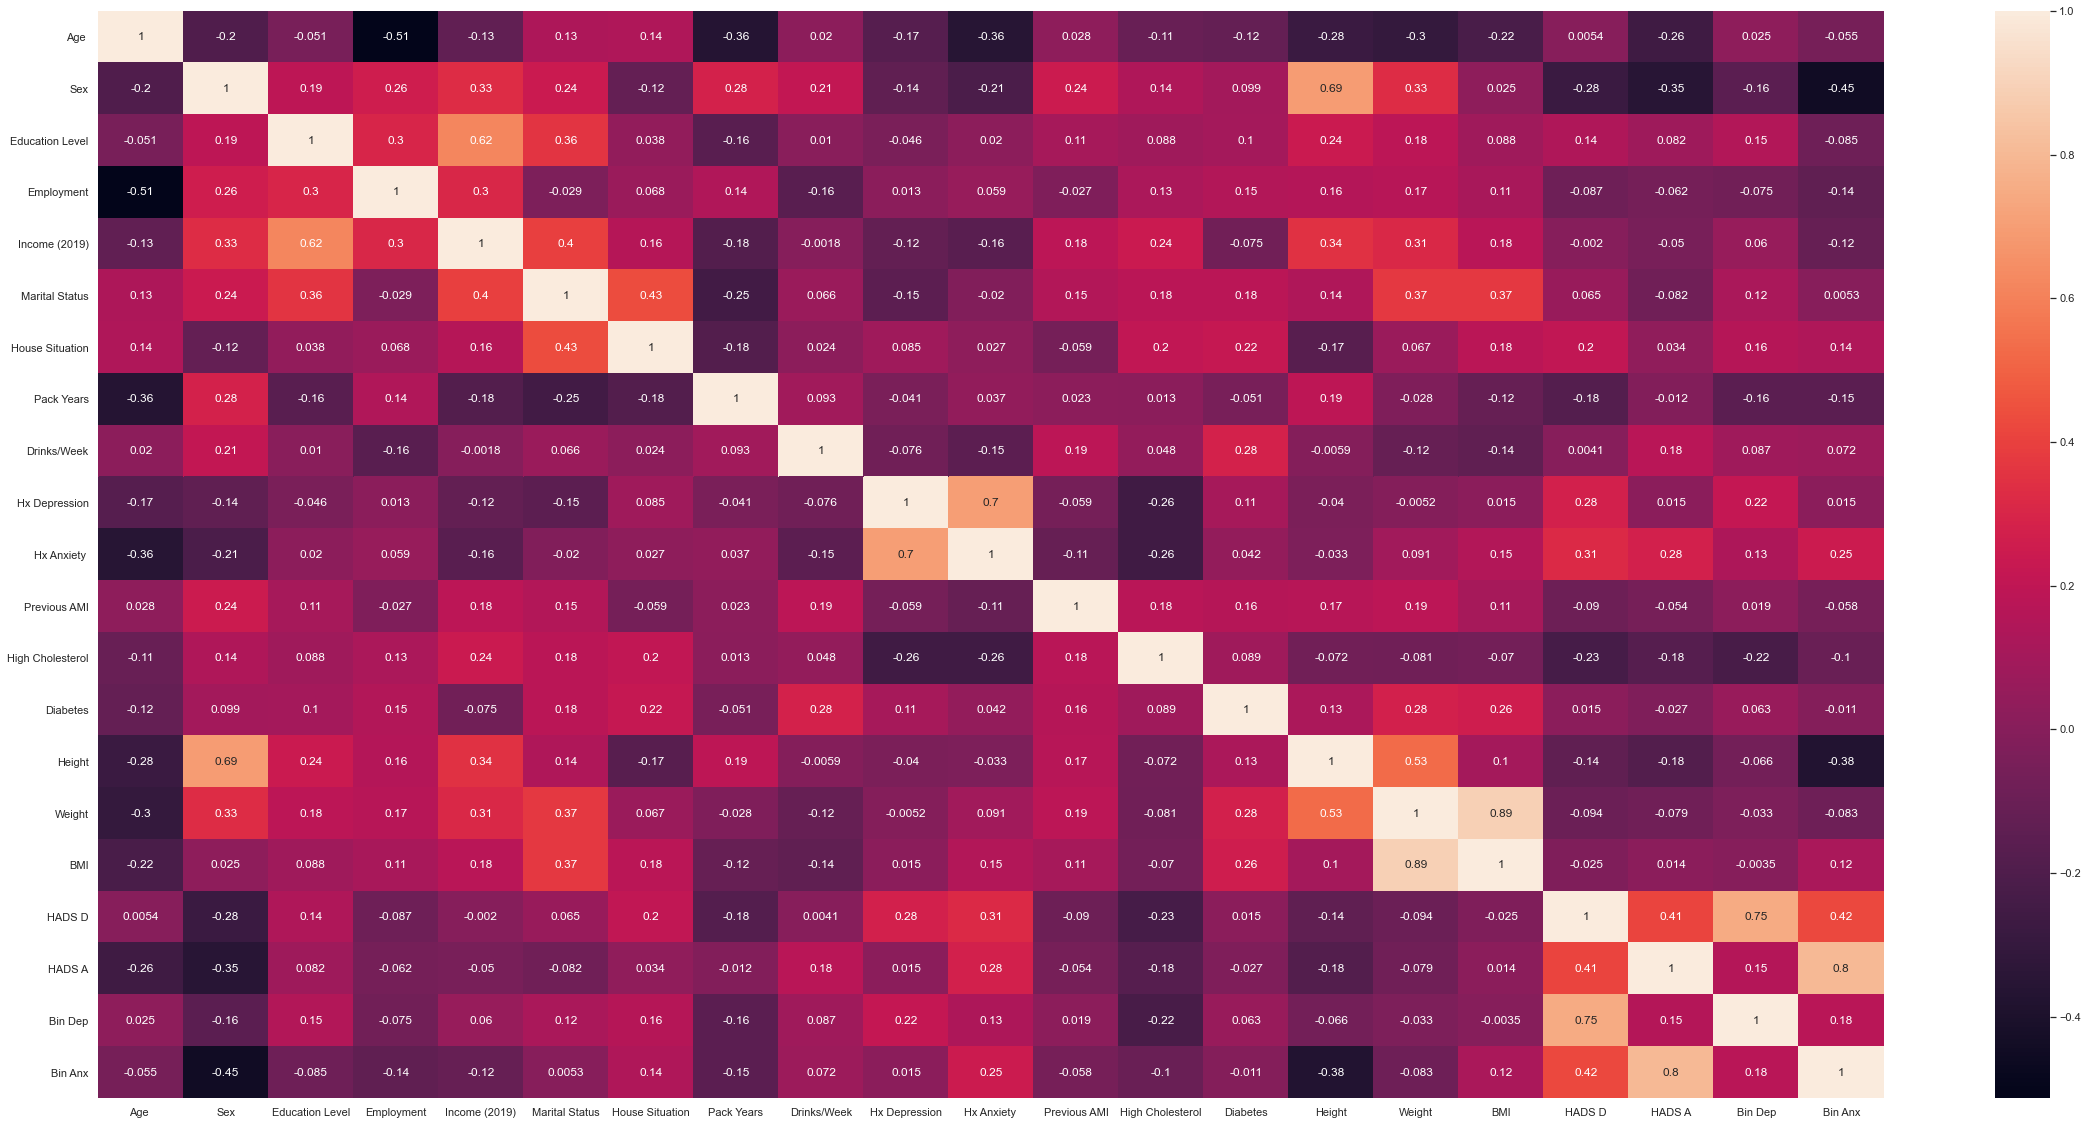

In [16]:
corrMatrix = data.corr()
fig = sn.heatmap(corrMatrix, annot=True)
plt.show()

## We can revisualize again with the colinear features removed

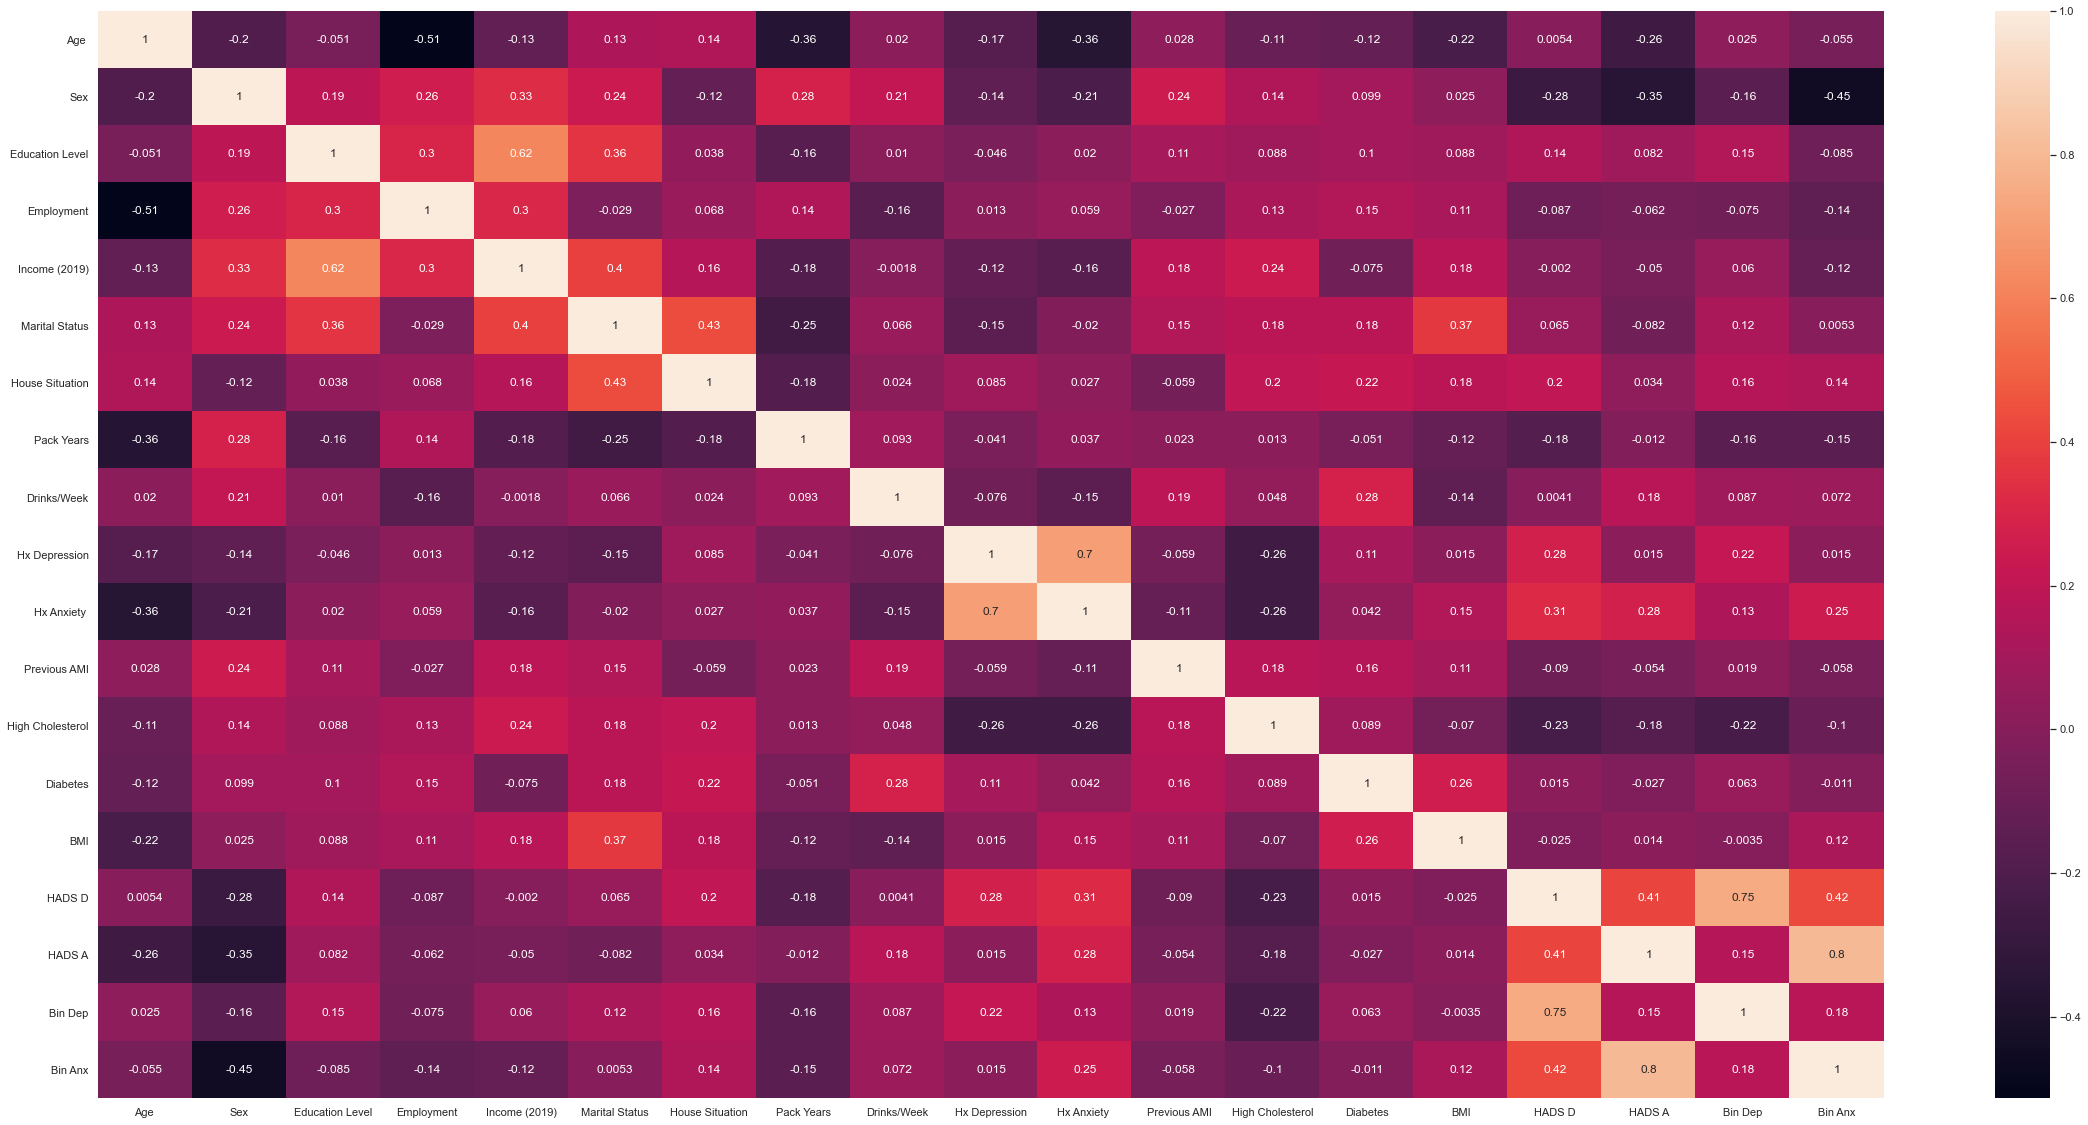

In [18]:
data_num2 = data.drop(columns = ['Height','Weight'])
corrMatrix2 = data_num2.corr()
fig = sn.heatmap(corrMatrix2, annot=True)
plt.show()

## We are interested in the correlation to the binary Anxiety or Depression calculation, so we will extract correlations from those rows

In [19]:
corrMatrix2['Bin Anx']

Age                -0.054840
Sex                -0.445823
Education Level    -0.084822
Employment         -0.139310
Income (2019)      -0.115847
Marital Status      0.005301
House Situation     0.139310
Pack Years         -0.154093
Drinks/Week         0.072286
Hx Depression       0.015456
Hx Anxiety          0.247808
Previous AMI       -0.057709
High Cholesterol   -0.102970
Diabetes           -0.011036
BMI                 0.119000
HADS D              0.422426
HADS A              0.803123
Bin Dep             0.176227
Bin Anx             1.000000
Name: Bin Anx, dtype: float64

In [20]:
corrMatrix2['Bin Dep']

Age                 0.025232
Sex                -0.158114
Education Level     0.150414
Employment         -0.074577
Income (2019)       0.059761
Marital Status      0.120331
House Situation     0.164069
Pack Years         -0.156287
Drinks/Week         0.086827
Hx Depression       0.219265
Hx Anxiety          0.134840
Previous AMI        0.019263
High Cholesterol   -0.224733
Diabetes            0.062622
BMI                -0.003546
HADS D              0.746625
HADS A              0.154486
Bin Dep             1.000000
Bin Anx             0.176227
Name: Bin Dep, dtype: float64

## As a preliminary analysis, we can see there are some variables that show some correlation, but the correlation is weak for the most part. This may suggestion that the relationship between the variables to the outcome is nonlinear and linear correlation analysis is insufficient.

## We can do some Biostat faves and look at Wilcoxon values for continuous (comparing to HADS A and HADS D, quasi-continuous, really, since it's all integer data) and Fisher values (comparing to 0/1 of depression or no depression) for binary data. 

In [24]:
print('Wilcoxon p values for continuous data, compared to HADS A score:')
for cols in data_num.columns:
    if cols != 'HADS A':
        w, p = wilcoxon(data_num[cols],data_num['HADS A'])
        print(cols, ': ', p)

    
print('\nWilcoxon p values for continuous data compared to HADS D score:')
for cols in data_num.columns:
    if cols != 'HADS D':
        w, p = wilcoxon(data_num[cols],data_num['HADS D'])
        print(cols, ': ', p)

Wilcoxon p values for continuous data, compared to HADS A score:
Age  :  1.614024597239049e-11
Pack Years :  2.1093283945513246e-08
Drinks/Week :  0.6506258685789152
Height :  1.581127256401653e-11
Weight :  1.6262344528596277e-11
BMI :  1.6295557943119345e-11
HADS D :  0.013104935567406635

Wilcoxon p values for continuous data compared to HADS D score:
Age  :  1.6170691757080703e-11
Pack Years :  1.3329398615078688e-08
Drinks/Week :  0.9576519253773318
Height :  1.590106087235418e-11
Weight :  1.6262344528596277e-11
BMI :  1.6295557943119345e-11
HADS A :  0.013104935567406635


## P-values look okay, but don't get too excited - the low-sample size may throw off the wilcoxon algorithm. The logistic regression p-value is what we really want to look at (later on)

## For the binary variables, we use Fisher's Exact Test. First, we need to convert categories into binary dummy variables

## Categorical variables converted to dummy variables with binary values (not needed after the exclusion of these variables, but may use this code later on - code is commented out for now

In [25]:
#cat_vars = ['Sex', 'Education Level', 'Employment', 'Income (2019)', 'Married', 'House Situation', 'Ethnicity',\
#           'People in House', 'Rooms in House','Rooms per Person', 'Pre-COVID Anxiety about Health', \
#           'Post-COVID Anxiety about Health']
#cont_vars = data_cont.columns
#data2 = data
#for var in cat_vars:
#    cat_list='var'+'_'+var
#    cat_list = pd.get_dummies(data[var], prefix=var)
#    data2=data2.join(cat_list)

#data3 = data2.drop(columns=cat_vars)
#data3 = data3.drop(columns=['Study ID'])
#data3 = data3.drop(columns = cont_vars)
#data3.columns

In [28]:
print('Fisher exact test for anxiety')
for cols in data_cat.columns:
    if cols != 'Bin Anx':
        data_crosstab = pd.crosstab(data_cat[cols],data_cat['Bin Anx'])
        oddsratio, pvalue = stats.fisher_exact(data_crosstab)
        print(cols, ': \t' ,pvalue)

print('\nFisher exact test for depression')
for cols in data_cat.columns:
    if cols != 'Bin Dep':
        data_crosstab = pd.crosstab(data_cat[cols],data_cat['Bin Dep'])
        oddsratio, pvalue = stats.fisher_exact(data_crosstab)
        print(cols, ': \t' ,pvalue)

Fisher exact test for anxiety
Sex : 	 0.0010749337452294527
Education Level : 	 0.5550063788820203
Employment : 	 0.36516895128567184
Income (2019) : 	 0.5417952888631892
Marital Status : 	 1.0
House Situation : 	 0.3651689512856721
Hx Depression : 	 1.0
Hx Anxiety  : 	 0.1074329459429581
Previous AMI : 	 1.0
High Cholesterol : 	 0.5443559332055071
Diabetes : 	 1.0
Bin Dep : 	 0.22206174416592733

Fisher exact test for depression
Sex : 	 0.2776284619849564
Education Level : 	 0.3050245785830767
Employment : 	 0.7323689759465852
Income (2019) : 	 0.7374960070587184
Marital Status : 	 0.4905432735189031
House Situation : 	 0.3021768854310956
Hx Depression : 	 0.12030570907038805
Hx Anxiety  : 	 0.37126577350568496
Previous AMI : 	 1.0
High Cholesterol : 	 0.16165211860224493
Diabetes : 	 0.6368305019116942
Bin Anx : 	 0.22206174416592808


## p-values are all over the place, especially for the binary variables likely due to low frequency and the algorithm thinks it's all due to chance, with the exception of a few variables. LIkely more samples are needed to elicit a meaningful Fisher test

## 3. Initial Attempt at Logistic Regression

## First removing colinear variables, similar to above. Note that categorical variables are not defined for VIF, colinearity is not well understood for those

In [40]:
data_final = data.drop(columns=['Weight','Height','HADS D','HADS A'])
data_final.columns

Index(['Age ', 'Sex', 'Education Level', 'Employment', 'Income (2019)',
       'Marital Status', 'House Situation', 'Pack Years', 'Drinks/Week',
       'Hx Depression', 'Hx Anxiety ', 'Previous AMI', 'High Cholesterol',
       'Diabetes', 'BMI', 'Bin Dep', 'Bin Anx'],
      dtype='object')

## Removing low-variance variables

In [41]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# min_variance = .9 * (1 - .9)  # You can play here with different values.
X = data_final
min_variance = 0.1
high_var_cols = variance_threshold_selector(X, min_variance) 
print('columns remaining: ', high_var_cols.columns )
print(len(high_var_cols.columns))
X_low_var_removed = data_final[high_var_cols.columns]
X_low_var_removed.columns

columns remaining:  Index(['Age ', 'Sex', 'Education Level', 'Employment', 'Income (2019)',
       'Marital Status', 'House Situation', 'Pack Years', 'Drinks/Week',
       'Hx Depression', 'Hx Anxiety ', 'Previous AMI', 'High Cholesterol',
       'Diabetes', 'BMI', 'Bin Dep', 'Bin Anx'],
      dtype='object')
17


Index(['Age ', 'Sex', 'Education Level', 'Employment', 'Income (2019)',
       'Marital Status', 'House Situation', 'Pack Years', 'Drinks/Week',
       'Hx Depression', 'Hx Anxiety ', 'Previous AMI', 'High Cholesterol',
       'Diabetes', 'BMI', 'Bin Dep', 'Bin Anx'],
      dtype='object')

# Now that no remaining variables are colinear, we can begin regression

# For Anxiety:

In [43]:
import statsmodels.api as sm

# for Anxiety
y = data_final['Bin Anx']
X = data_final.drop(columns = ['Bin Anx', 'Bin Dep'])

print(X.columns)
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())


Index(['Age ', 'Sex', 'Education Level', 'Employment', 'Income (2019)',
       'Marital Status', 'House Situation', 'Pack Years', 'Drinks/Week',
       'Hx Depression', 'Hx Anxiety ', 'Previous AMI', 'High Cholesterol',
       'Diabetes', 'BMI'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.355882
         Iterations 7
                         Results: Logit
Model:               Logit            Pseudo R-squared: 0.345   
Dependent Variable:  Bin Anx          AIC:              72.7059 
Date:                2020-09-05 21:40 BIC:              104.1210
No. Observations:    60               Log-Likelihood:   -21.353 
Df Model:            14               LL-Null:          -32.596 
Df Residuals:        45               LLR p-value:      0.069149
Converged:           1.0000           Scale:            1.0000  
No. Iterations:      7.0000                                     
----------------------------------------------------------------
    

# Refactoring variables and repeating logistic regression fit

## P values are not very good, this is most likely due to undersampling (rule of thumb is 10x the number of variables needed as a sample size). What we can do is remove the very low statistical power variables and re-fit

In [50]:
low_sig_cols = ['Education Level', 'Previous AMI', 'Employment', 'Marital Status','Income (2019)',\
                'Diabetes', 'Pack Years','BMI']
X2 = X.drop(columns=low_sig_cols)
print(X2.columns)
logit_model=sm.Logit(y,X2)
result=logit_model.fit()
print(result.summary2())


Index(['Age ', 'Sex', 'House Situation', 'Drinks/Week', 'Hx Depression',
       'Hx Anxiety ', 'High Cholesterol'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.377143
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.306    
Dependent Variable: Bin Anx          AIC:              59.2572  
Date:               2020-09-05 21:43 BIC:              73.9176  
No. Observations:   60               Log-Likelihood:   -22.629  
Df Model:           6                LL-Null:          -32.596  
Df Residuals:       53               LLR p-value:      0.0028435
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
Age  

## Repeating the same but with depression instead of anxiety

In [51]:
y = data_final['Bin Dep']
X = data_final.drop(columns = ['Bin Anx', 'Bin Dep'])

print(X.columns)
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Index(['Age ', 'Sex', 'Education Level', 'Employment', 'Income (2019)',
       'Marital Status', 'House Situation', 'Pack Years', 'Drinks/Week',
       'Hx Depression', 'Hx Anxiety ', 'Previous AMI', 'High Cholesterol',
       'Diabetes', 'BMI'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.329853
         Iterations 8
                        Results: Logit
Model:              Logit            Pseudo R-squared: 0.268   
Dependent Variable: Bin Dep          AIC:              69.5823 
Date:               2020-09-05 21:44 BIC:              100.9975
No. Observations:   60               Log-Likelihood:   -19.791 
Df Model:           14               LL-Null:          -27.034 
Df Residuals:       45               LLR p-value:      0.41424 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     8.0000                                     
---------------------------------------------------------------
              

In [64]:
low_sig_cols = ['Employment', 'Income (2019)', 'Pack Years', 'Diabetes', 'BMI', 'Marital Status',\
               'House Situation', 'Hx Anxiety ']
X2 = X.drop(columns=low_sig_cols)
print(X2.columns)
logit_model=sm.Logit(y,X2)
result=logit_model.fit()
print(result.summary2())

Index(['Age ', 'Sex', 'Education Level', 'Drinks/Week', 'Hx Depression',
       'Previous AMI', 'High Cholesterol'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.366496
         Iterations 7
                         Results: Logit
Model:                Logit            Pseudo R-squared: 0.187  
Dependent Variable:   Bin Dep          AIC:              57.9795
Date:                 2020-09-05 21:47 BIC:              72.6399
No. Observations:     60               Log-Likelihood:   -21.990
Df Model:             6                LL-Null:          -27.034
Df Residuals:         53               LLR p-value:      0.12100
Converged:            1.0000           Scale:            1.0000 
No. Iterations:       7.0000                                    
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
Age 


## We see some variables achieving a statistically significant maximum likelihood fit as well.

## However, the fit is quite counter-intuitive, variables we expect to affect the outomce resulted in a very low P-value. Excluding thesevariable, although it improves convergence and validiy of the model, likely excludes important independent variables we want to explore.

## The takeaway from this is that not enough samples are available to create a fit using all the variables.  tasks would then be required to improve the model:

### 1. Acquiring more data
### 2. Deciding which variables to exclude in both a mathematical way (covariance, colinearity) and manually using biological plausibility, but this is up to the study designer.
### 3. Refactoring definition of data (e.g. income level can be a cutoff dependent on number of people in house, too many categories for education). Essentially whenever there's an N-way split of categories, you need and extra 10N samples.
